In [ ]:
!pip install torchsummary

In [ ]:
import os, glob, gc, cv2, time, re, torch
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from PIL import Image

import pytorch_lightning as pl
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torchsummary import summary
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image


from tqdm import tqdm

from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from shutil import copytree, copy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

# Data reading

In [ ]:
# path where dataset is located
path_train = "/kaggle/input/land-full/train_images/train_images_folder"
path_test = "/kaggle/input/land-full/test_images/test_images_folder"


In [ ]:
def rgb_to_lab(rgb):
    ' PIL RGB to Lab (L channel, ab channel)'
    img = rgb2lab(rgb).astype('float32')
    L = (img[...,0:1]/50.)-1. #[0,100] -> [-1,1]
    ab = img[...,1:]/128 #[-128,128] -> [-1,1]
    return {'L': L, 'ab': ab}

In [ ]:
def lab_to_rgb(L, ab):  
    L = (L + 1.) * 50. #[-1,1] -> [0,100]
    ab = ab * 128. #[-1,1] -> [-128,128]
    Lab = np.concatenate((L,ab), axis=3)
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [ ]:
def lab_to_rgb_pytorch(L, ab):
  """lab_to_rgb takes a numpy stack [B, H, W ,C] as input and
     return a numpy stack in the same format"""
  L = L.permute(0, 2, 3, 1).cpu().numpy()
  ab = ab.permute(0, 2, 3, 1).detach().cpu().numpy()
  return torch.from_numpy(lab_to_rgb(L, ab)).permute(0, 3, 1, 2)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, paths, im_size=256, split='train'):
        self.split = split
        self.paths = paths
        self.total_imgs = os.listdir(paths)

        #Train: resize+data augmentation
        if self.split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((im_size, im_size)),
                transforms.RandomHorizontalFlip(), 
            ])
        #Test: resize
        elif self.split == 'test':
            self.transforms = transforms.Resize((im_size, im_size))

        

  def __len__(self):
        return len(self.total_imgs)

  def __getitem__(self, index):
        #RGB reading
        img_loc = os.path.join(self.paths, self.total_imgs[index])
        img = Image.open(img_loc).convert('RGB')


        #Transformation and Lab conversion
        img_input = self.transforms(img)
        img_lab = rgb_to_lab(img_input)

        return {'L': transforms.ToTensor()(img_lab['L']), 'ab': transforms.ToTensor()(img_lab['ab'])}
     


In [ ]:
def make_dataloaders(batch_size=16, im_size=256, split='Train', n_workers=2, pin_memory=True, shuffle=True, **kwargs):
    dataset = ImageDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
IM_SIZE = 256
BATCH_SIZE = 64
nb_of_output_channels = 2 #L and Ab

In [ ]:
generator = make_dataloaders(batch_size=BATCH_SIZE, im_size=IM_SIZE, split='Train', paths=path_train, n_workers=2)
track_train = make_dataloaders(batch_size=5, im_size=IM_SIZE, split='Train', paths=path_train, n_workers=2, shuffle=False)
track_test = make_dataloaders(batch_size=100, im_size=IM_SIZE, split='Test', paths=path_test, n_workers=2, shuffle=False)

In [ ]:
track_train_batch = next(iter(track_train))
color = lab_to_rgb_pytorch(track_train_batch['L'], track_train_batch['ab'])
color_grid_real_train = vutils.make_grid(color.to(device), padding=2, normalize=True, nrow=5).cpu()
bw_grid_train = vutils.make_grid(track_train_batch['L'].to(device), padding=2, normalize=True, nrow=5).cpu()
fig, ax = plt.subplots(2, 1, figsize=(16, 6))
plt.tight_layout()
ax[0].set_title('Training Images')
ax[0].imshow(np.transpose(color_grid_real_train,(1,2,0)))
ax[0].set_axis_off()
ax[1].imshow(np.transpose(bw_grid_train,(1,2,0)))
ax[1].set_axis_off()
fig.subplots_adjust(hspace=0.)

Test batches and all test images plot (commented for memory purposes)

In [ ]:
track_test_batch = next(iter(track_test))
color = lab_to_rgb_pytorch(track_test_batch['L'], track_test_batch['ab'])
color_grid_real_test = vutils.make_grid(color.to(device), padding=2, normalize=True, nrow=5).cpu()
bw_grid_test = vutils.make_grid(track_test_batch['L'].to(device), padding=2, normalize=True, nrow=5).cpu()
#fig, ax = plt.subplots(2, 1, figsize=(200, 200))
#plt.tight_layout()
#ax[0].set_title('Test Images')
#ax[0].imshow(np.transpose(color_grid_real_test,(1,2,0)))
#ax[0].set_axis_off()
#ax[1].imshow(np.transpose(bw_grid_test,(1,2,0)))
#ax[1].set_axis_off()
#fig.subplots_adjust(hspace=0.)
#save_image(color_grid, os.path.join(img_test, 'train_color.png'))
#save_image(bw_grid, os.path.join(img_test, 'train_bw.png'))

# Model

In [ ]:
def downsample(in_channels, out_channels, size, apply_batchnorm=True, bias=False):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=size, stride=2, padding=1,bias=bias))
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2,True))
    return nn.Sequential(*layers)

def upsample(in_channels, out_channels, size, apply_dropout=False):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=size, stride=2, padding=1, bias=False))
    layers.append(nn.BatchNorm2d(out_channels))
    if apply_dropout:
        layers.append(nn.Dropout(0.5))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

## Generator (U-Net)

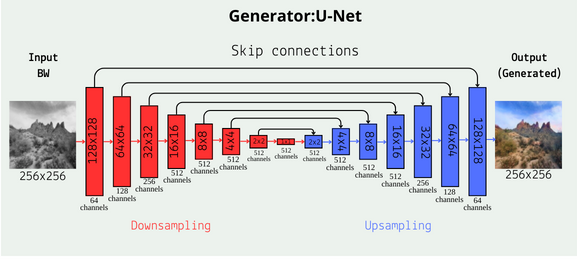

In [ ]:
class Generator(nn.Module):
    def __init__(self, nb_output_channels=2):
        super(Generator, self).__init__()
        self.down_stack = nn.ModuleList([
            downsample(1,64, 4, apply_batchnorm=False), 
            downsample(64,128, 4), 
            downsample(128,256, 4), 
            downsample(256,512, 4),  
            downsample(512,512, 4),  
            downsample(512,512, 4),  
            downsample(512,512, 4),
            downsample(512,512, 4, apply_batchnorm=False)  
        ])
        self.up_stack = nn.ModuleList([
            upsample(512,512, 4, apply_dropout=True), 
            upsample(512*nb_output_channels,512, 4),  
            upsample(512*nb_output_channels,512, 4),  
            upsample(512*nb_output_channels,512, 4),  
            upsample(512*nb_output_channels,256, 4), 
            upsample(256*nb_output_channels,128, 4),  
            upsample(128*nb_output_channels,64, 4) 
        ])
                                        #in_channels is 128=64*2 (L and ab channels)
        self.last = nn.ConvTranspose2d(in_channels=64*nb_output_channels, out_channels=nb_output_channels, kernel_size=4, stride=2, padding=1)
        self.activation = nn.Tanh() #since the images are coded in Lab format


    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        x = self.activation(self.last(x))
        return x


## Discriminator (PatchGAN)

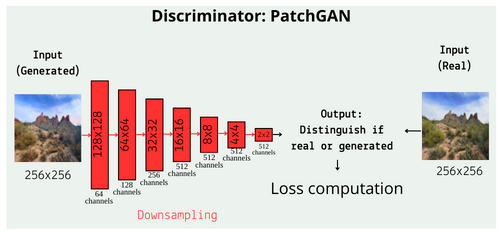

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.down1 = downsample(3,64,4, apply_batchnorm=False,bias=True)
        self.down2 = downsample(64,128, 4)
        self.down3 = downsample(128,256, 4)
        self.pad1 = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.last = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1,bias=True)
        self.activation = nn.Sigmoid()
        
    def forward(self, inp):
        x = self.down1(inp)
        x = self.down2(x)
        x = self.down3(x)
        x = self.pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.last(x)
        x = self.leaky_relu(x)
        x = self.pad1(x)
        x = self.activation(x)
        return x

In [ ]:
class DiscriminatorLoss(nn.Module):
  def __init__(self, device):
      super().__init__()
      self.register_buffer('real_labels', torch.ones([30,30], requires_grad=False, device=device), False)
      self.register_buffer('fake_labels', torch.zeros([30,30], requires_grad=False, device=device), False)
      # Mean Squared Error (MSE)
      self.loss = nn.MSELoss()

  def forward(self, predictions, check_real):
        if check_real:
            target = self.real_labels
        else:
            target = self.fake_labels
        return self.loss(predictions, target.expand_as(predictions))

## Weights

In [ ]:
@torch.no_grad()
def init_weights(m, gain=0.02):
  if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
    nn.init.normal_(m.weight.data, mean=0.0, std=gain)
    if m.bias is not None:
        nn.init.constant_(m.bias.data, 0.0)
  elif type(m) == nn.BatchNorm2d:
    nn.init.normal_(m.weight.data, 1., gain)
    nn.init.constant_(m.bias.data, 0.)

In [ ]:
show_summary = True

In [ ]:
if show_summary:
  if torch.cuda.is_available():  
    dev = "cuda:0" 
  else:  
    dev = "cpu"  
  device = torch.device(dev)

  net_G = Generator(2).to(device)
  net_D = Discriminator().to(device)

  summary(net_G, (1, 256, 256))
  summary(net_D, (3, 256, 256))

# Execution

In [ ]:
net_G = Generator(nb_of_output_channels).to(device)
net_D = Discriminator().to(device)

In [ ]:
opt_G = optim.Adam(net_G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(net_D.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
net_G = net_G.apply(init_weights).train()
net_D = net_D.apply(init_weights).train()

In [ ]:
GANcriterion = DiscriminatorLoss(device)
criterion = nn.L1Loss()
lambda1 = 100

In [ ]:
# Function to obtain plot (training over epochs, final epoch evaluation on test)
# depending on data_type ('train' or 'test')
def visualize_data(data_type, color_grid_real, bw_grid, color_grid):
    if data_type=='train':
        fig_size = (16,6)
    else:
        fig_size=(200, 200)
        
    fig, ax = plt.subplots(3, 1, figsize=fig_size)
    plt.tight_layout()

    ax[0].set_title(f'Real ({data_type})')
    ax[0].imshow(np.transpose(color_grid_real,(1,2,0)))
    ax[0].set_axis_off()

    ax[1].set_title('BW')
    ax[1].imshow(np.transpose(bw_grid,(1,2,0)))
    ax[1].set_axis_off()

    ax[2].set_title('Colorized')
    ax[2].imshow(np.transpose(color_grid,(1,2,0)))
    ax[2].set_axis_off()

    fig.subplots_adjust(hspace=0.5)
    plt.show()


In [ ]:
epochs = 60

In [ ]:
for epoch in range(epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0
    for i, data in tqdm(enumerate(generator)):
        
          L, ab = data['L'].to(device), data['ab'].to(device)
          fake_color = net_G(L)
          real_image = torch.cat([L, ab], dim=1)
          fake_image = torch.cat([L, fake_color], dim=1)

          #Discriminator Train
          opt_D.zero_grad()
          #train on real images
          real_preds = net_D(real_image)
          loss_D_real = GANcriterion(real_preds, True)      
          #train on fake images
          fake_preds = net_D(fake_image.detach())
          loss_D_fake = GANcriterion(fake_preds, False)
          #total loss for D
          loss_D = (loss_D_fake + loss_D_real) * 0.5
          loss_D.backward()
          opt_D.step()

          #Generator Train
          opt_G.zero_grad()
          fake_preds = net_D(fake_image)
          loss_G_GAN = GANcriterion(fake_preds, True)
          loss_G_L1 = criterion(fake_color, ab) * lambda1

          #Generator Loss
          loss_G = loss_G_GAN + loss_G_L1
          loss_G.backward()
          opt_G.step()

          epoch_loss_D += loss_D.item()
          epoch_loss_G += loss_G.item()

    epoch_loss_D = epoch_loss_D/(i+1)
    epoch_loss_G = epoch_loss_G/(i+1)

    print('[%d, %d] loss: %.3f %.3f' %
                (epoch+1, epochs, epoch_loss_G, epoch_loss_D))
    

    
    color_train = lab_to_rgb_pytorch(track_train_batch['L'].to(device), net_G(track_train_batch['L'].to(device)))
    

    color_train_grid = vutils.make_grid(color_train.to(device), padding=2, normalize=True, nrow=5).cpu() 
    
    
    visualize_data('Train', color_grid_real_train, bw_grid_train, color_train_grid)
    
    
    # Print test batches only at the end of training (last epoch)
    if epoch==epochs-1:
        # Save final model results
        torch.save({'epoch': epoch,
              'G_state_dict': net_G.state_dict(),
               'D_state_dict': net_D.state_dict(),
             'optimizerG_state_dict': opt_G.state_dict(),
               'optimizerD_state_dict': opt_D.state_dict(),
                'loss_G': loss_G,
                'loss_D': loss_D
                },'finalmodel.pt')
        
        color_test = lab_to_rgb_pytorch(track_test_batch['L'].to(device), net_G(track_test_batch['L'].to(device)))
        color_test_grid = vutils.make_grid(color_test.to(device), padding=2, normalize=True, nrow=5).cpu()
        visualize_data('Test', color_grid_real_test, bw_grid_test, color_test_grid)

# Save colorized images (test)

In [ ]:
real_test = color.to(device)
bw_test = track_test_batch['L'].to(device)
for i in range(color_test.size(0)):
    img = color_test[i]
    img_real = real_test[i]
    img_bw = bw_test[i]
    img = img.unsqueeze(0)
    img_real = img_real.unsqueeze(0)
    img_bw = img_bw.unsqueeze(0)
    # Save each version of the image
    vutils.save_image(img, f'{i}_colorized_test.jpg')
    vutils.save_image(img_real, f'{i}_real_test.jpg')
    vutils.save_image(img_bw, f'{i}_bw_test.jpg')


# Evaluation Metrics

In [ ]:
real_test = color.to(device)
bw_test = track_test_batch['L'].to(device)

# Initialize lists to store PSNR and SSIM values
psnr_values = []
ssim_values = []

for i in range(color_test.size(0)):
    # Select the image from the batch
    img = color_test[i].cpu().numpy()
    img_real = real_test[i].cpu().numpy()

    # Compute PSNR and SSIM and append to respective lists
    psnr_values.append(psnr(img_real, img))
    ssim_values.append(ssim(img_real, img,data_range=255,channel_axis=0))

# Compute the mean PSNR and SSIM
mean_psnr = sum(psnr_values) / len(psnr_values)
mean_ssim = sum(ssim_values) / len(ssim_values)

print(f"Mean PSNR: {mean_psnr}")
print(f"Mean SSIM: {mean_ssim}")


## Export in zip

In [ ]:
!zip -r file.zip /kaggle/working